# Imports

In [1]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
#import pyaudio
import numpy as np
import sounddevice as sd
import cv2
from scipy.signal import iirnotch, filtfilt
from glob import glob

In [2]:
#data_dir = 
subject_dirs = [x for x in glob("E:\CUNY\*") if "." not in x]
glob(subject_dirs[1]+'/*')

IndexError: list index out of range

# Load Data

In [2]:
xdf_path = "/Users/bryan.gonzalez/PycharmProjects/MOBI2024/CUNY_FACIAL/Data/real_subjects/sub-P5342811/sub-P5342811_ses-S001_task-CUNY_run-001_mobi.xdf"
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]
streams_collected

['WebcamStream',
 'Stimuli_Markers',
 'Tobii',
 'EGI NetAmp 0',
 'OpenSignals',
 'Microphone']

# Stimulus

In [3]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_ExperimentStart',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_ExperimentEnd',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,200,Onset_ExperimentStart,107286.889945,0.000000e+00
1,1727814220,psychopy_time_stamp,107286.889956,1.099997e-08
2,10,Onset_RestingState,107309.132565,2.224262e-02
3,1727814242,psychopy_time_stamp,107309.132576,2.224263e-02
4,11,Offset_RestingState,107609.133231,3.222433e-01
...,...,...,...,...
256,1727816600,psychopy_time_stamp,109666.911876,2.380022e+00
257,201,Offset_ExperimentEnd,109671.914631,2.385025e+00
258,1727816605,psychopy_time_stamp,109671.914645,2.385025e+00
259,4,Bx_input,109671.914758,2.385025e+00


In [4]:
def get_event_data(event, df, stim_df=stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]




In [5]:
# confirm all events are in the stim_df
evs = stim_df.loc[stim_df.event != 'psychopy_time_stamp']
evs

,trigger,event,lsl_time_stamp,time
0,200,Onset_ExperimentStart,107286.889945,0.000000
2,10,Onset_RestingState,107309.132565,0.022243
4,11,Offset_RestingState,107609.133231,0.322243
6,500,Onset_StoryListening,107609.133303,0.322243
8,100,Onset_10second_rest,107681.366707,0.394477
...,...,...,...,...
251,401,Offset_impedanceCheck,109342.532208,2.055642
253,80,Onset_SocialTask,109366.405067,2.079515
255,81,Offset_SocialTask,109666.911857,2.380022
257,201,Offset_ExperimentEnd,109671.914631,2.385025


In [6]:
def get_secs_between_triggers(trigger1, trigger2):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

# Get a list of the story names using the events dict
#story_names = [x.split('_')[1] for x in list(events.values())[2:][::2]]
#story_names



In [8]:
files= [
    "../audio_files/audio_files/After_Searching_I_Found_and_Met_My_Birth_Mother.wav",
    "../audio_files/audio_files/Camp_Lose_A_Friend.wav",
    "../audio_files/audio_files/Frog_Dissection_Disaster.wav",
    "../audio_files/audio_files/I_Decided_To_Be_Myself_And_Won_A_Dance_Contest.wav",
    "../audio_files/audio_files/I_Fully_Embarrassed_Myself_In_Zoom_Class1.wav",
    "../audio_files/audio_files/Left_Home_Alone_in_a_Tornado.wav",
    "../audio_files/audio_files/The_Birthday_Party_Prank.wav",
    "../audio_files/audio_files/My_Dad_Saw_Me_Wearing_Glitter_At_School.wav"
]


durations = pd.DataFrame({
    'trigger':story_onsets,
    'story':[events[x] for x in story_onsets],
    'lsl_duration': [get_secs_between_triggers(x+1, x) for x in story_onsets],
    'audiofile_duration': [wave.open(x).getnframes()/wave.open(x).getframerate() for x in files] #duration of audio file is number of frames divided by the frame rate.
})

durations['difference(sec)'] = durations['audiofile_duration'] - durations['lsl_duration']
durations

ValueError: All arrays must be of the same length

# Making sure durations are correct

In [10]:
exp_start = stim_df.loc[stim_df.event == 'Onset_ExperimentStart', 'lsl_time_stamp'].values[0]
exp_end = stim_df.loc[stim_df.event == 'Offset_ExperimentEnd', 'lsl_time_stamp'].values[0]
exp_end - exp_start


2385.0246855907026

# Physio

In [7]:
PS = data[streams_collected.index('OpenSignals')]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000

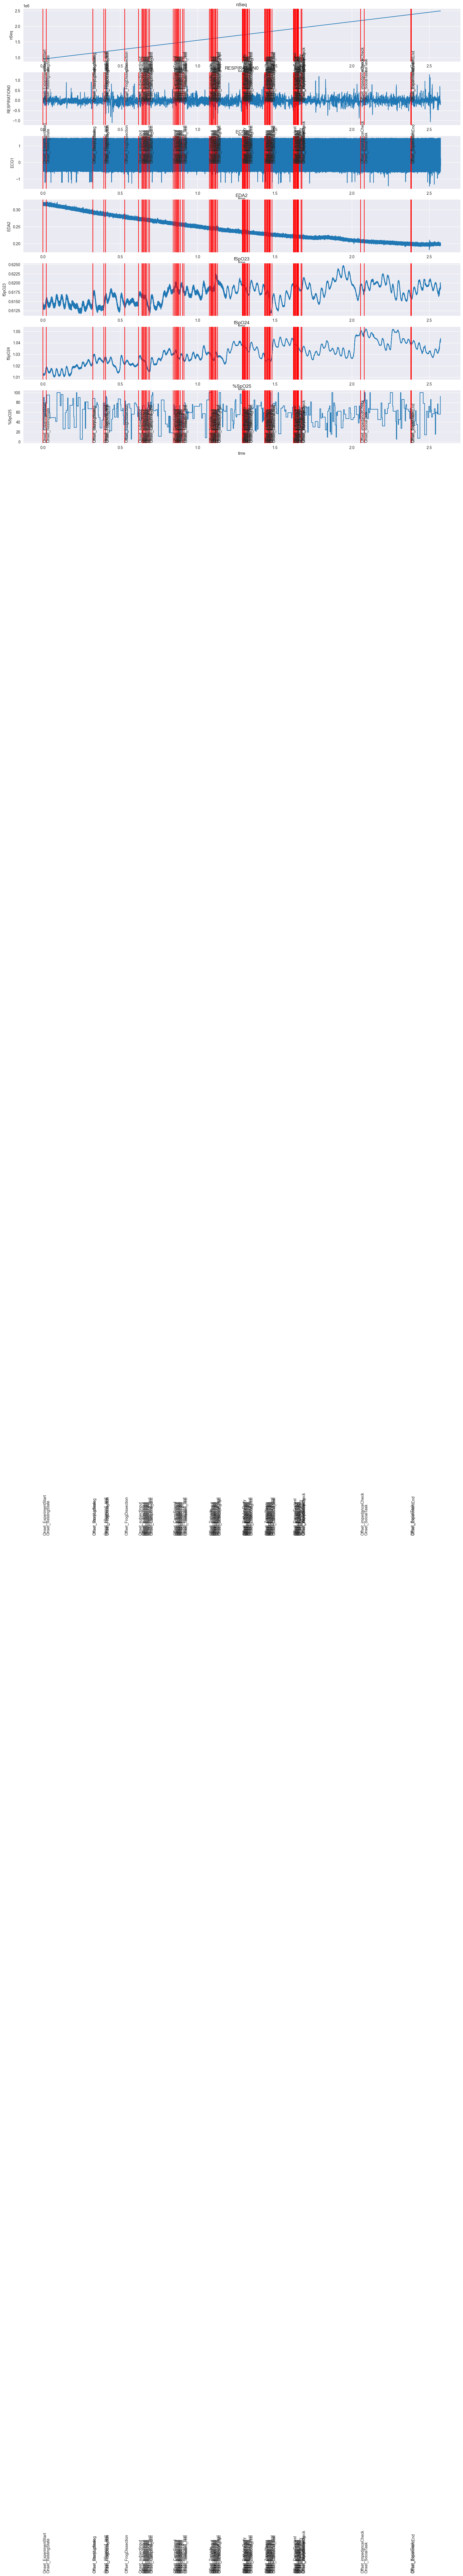

In [11]:
    
'''
# Plot every column in one plot
'''
f, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
for i, col in enumerate(column_labels):
    
    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=ps_df, x='time', y=col, ax=ax[i])
    # Place and Vline at every event in evs with onset and offset
    for event in evs.iterrows():
        # If the word Onset or Offset is in the event, plot a vertical line at the time of the event

        if "Onset" in event[1]['event'] or "Offset" in event[1]['event']:
            ax[i].axvline(event[1]['time'], color='r')
            ax[i].text(event[1]['time'], 0, event[1]['event'], rotation=90)
        
    ax[i].set_title(col)
    #plt.show()

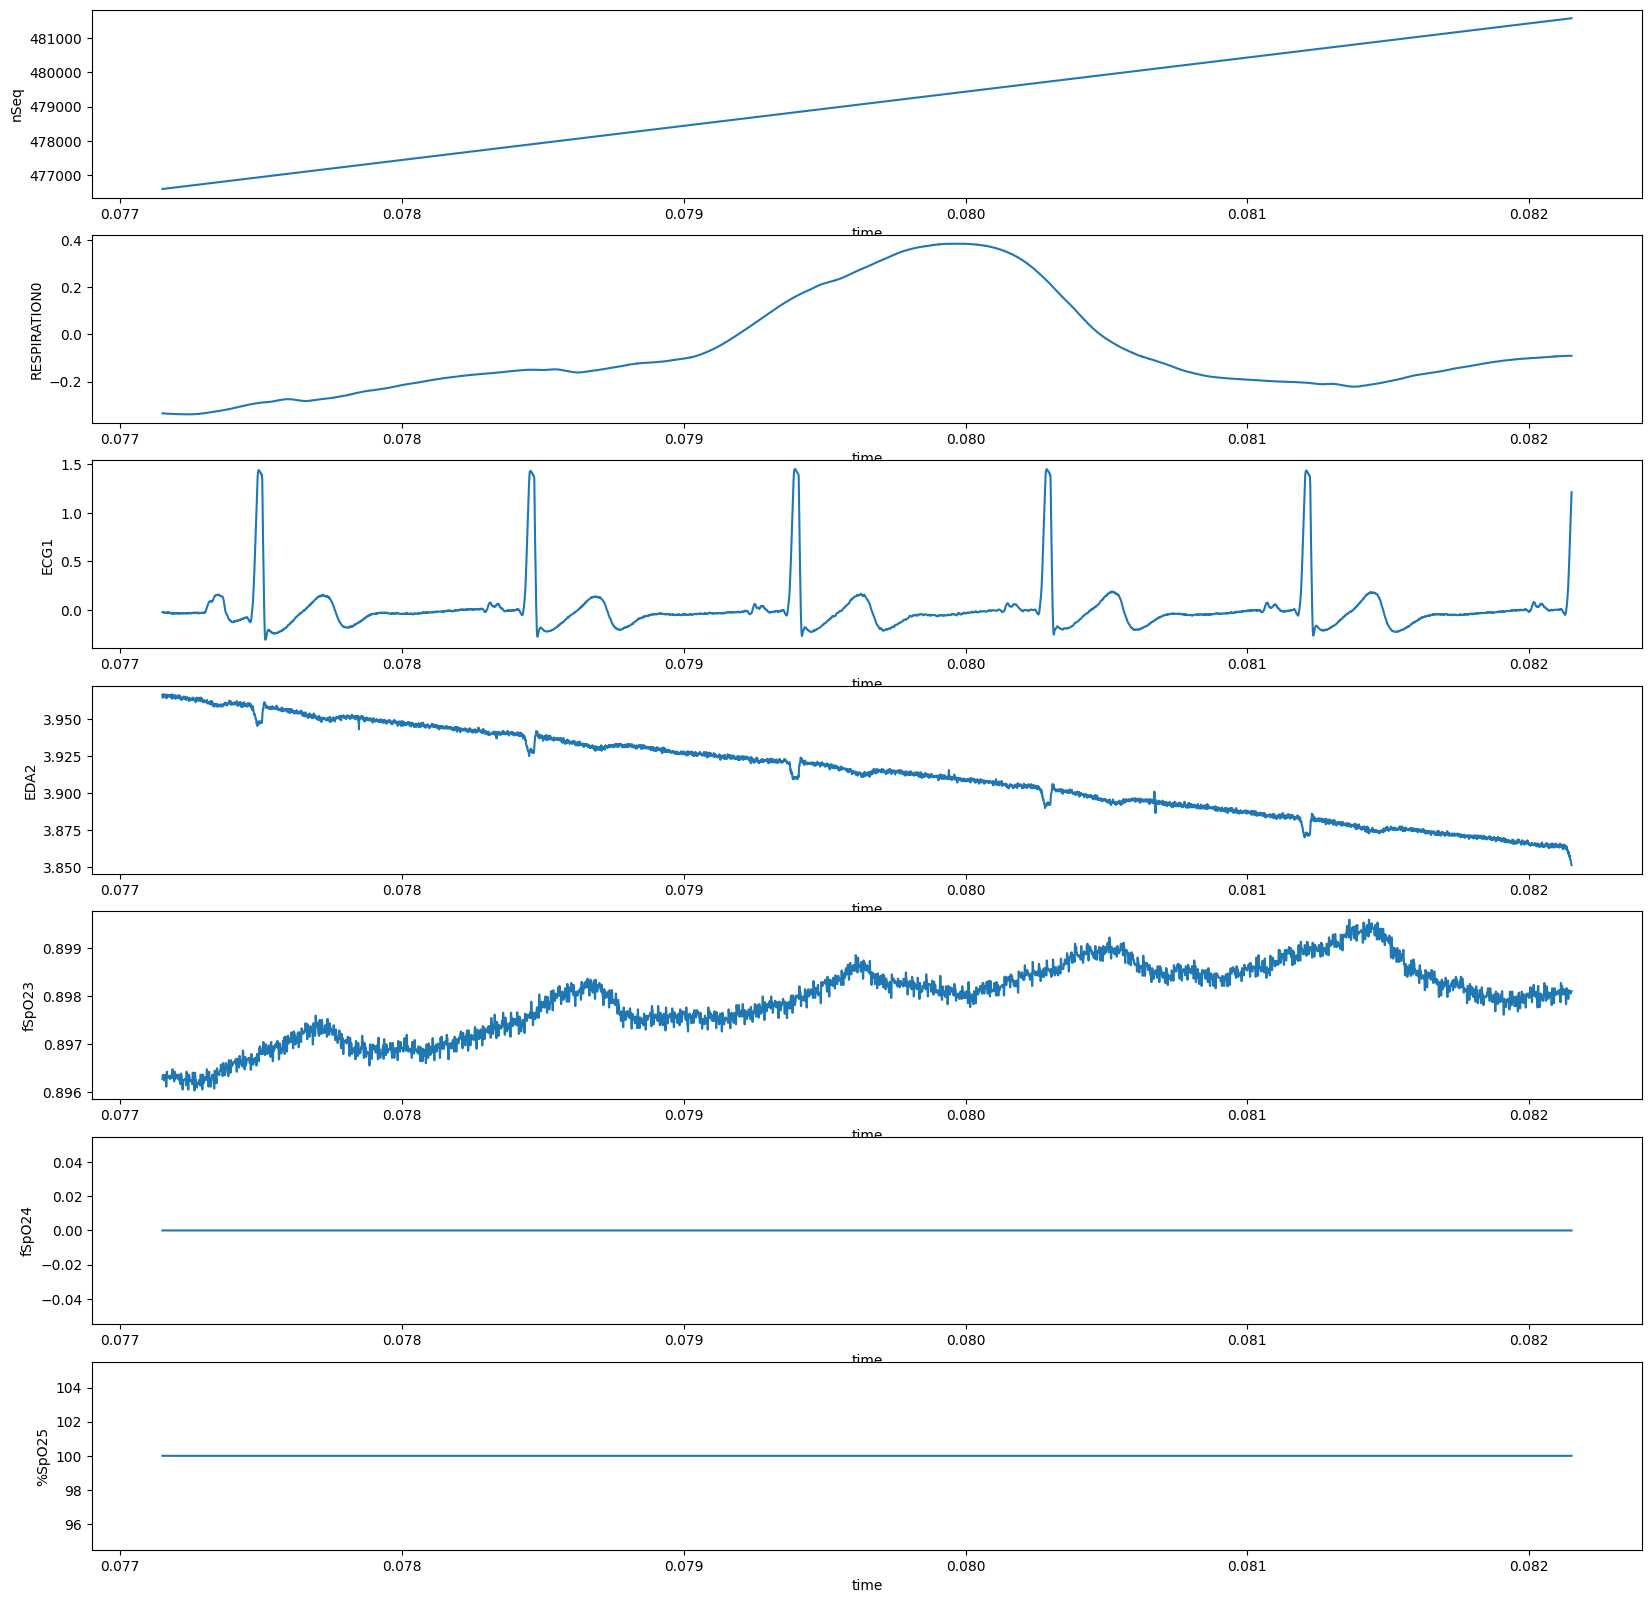

In [15]:
physio_resting_state = get_event_data('RestingState', ps_df)
fig, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
#for i, col in enumerate(['RESPIRATION0', 'fSpO21', 'fSpO22', '%SpO23']):
for i, col in enumerate(column_labels):
    

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=physio_resting_state[:5000], x='time', y=col, ax=ax[i])

# Linking Microphone Data to Video Data

In [17]:
mic_data = data[streams_collected.index('Microphone')]
mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
mic_df['lsl_time_stamp'] = mic_data['time_stamps']
mic_df['time'] = (mic_data['time_stamps'] - mic_data['time_stamps'][0])/441000
mic_df.head()

,int_array,bytestring,lsl_time_stamp,time
0,15,b'\x0f\x00\x00\x00',5719.807677,0.000000e+00
1,21,b'\x15\x00\x00\x00',5719.807699,5.141978e-11
2,24,b'\x18\x00\x00\x00',5719.807722,1.028396e-10
3,30,b'\x1e\x00\x00\x00',5719.807745,1.542593e-10
4,35,b'#\x00\x00\x00',5719.807767,2.056791e-10


In [18]:
#conversation_onset_stim = stim_df.loc[stim_df.event == 'Onset_SocialTask', 'time'].values[0]
#conversation_offset_stim = stim_df.loc[stim_df.event == 'Offset_SocialTask', 'time'].values[0]
#
# convo = mic_df.loc[(mic_df['time'] > conversation_onset_stim ) & (mic_df['time'] < conversation_offset_stim), 'int_array'].values
convo = get_event_data('Tornado', mic_df)
convo


,int_array,bytestring,lsl_time_stamp,time
17036643,-42,b'\xd6\xff\xff\xff',6106.132686,0.000876
17036644,-41,b'\xd7\xff\xff\xff',6106.132709,0.000876
17036645,-43,b'\xd5\xff\xff\xff',6106.132732,0.000876
17036646,-46,b'\xd2\xff\xff\xff',6106.132754,0.000876
17036647,-47,b'\xd1\xff\xff\xff',6106.132777,0.000876
...,...,...,...,...
24235642,-30,b'\xe2\xff\xff\xff',6269.378072,0.001246
24235643,-29,b'\xe3\xff\xff\xff',6269.378095,0.001246
24235644,-30,b'\xe2\xff\xff\xff',6269.378117,0.001246
24235645,-28,b'\xe4\xff\xff\xff',6269.378140,0.001246


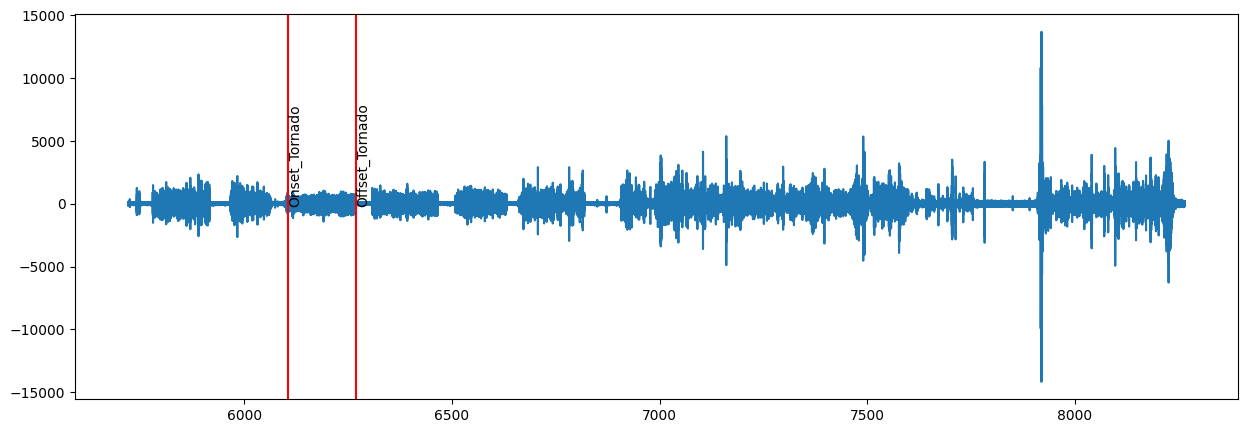

In [19]:
f, ax = plt.subplots(figsize=(15, 5))
plt.plot(mic_df.lsl_time_stamp, mic_df.int_array)
for event in evs.loc[evs.event.str.contains('Tornado')].iterrows():
    ax.axvline(event[1]['lsl_time_stamp'], color='r')
    ax.text(event[1]['lsl_time_stamp'], 0, event[1]['event'], rotation=90)
        

In [21]:
sd.play(convo.int_array.values)

# Video Data
Now lets open the video frames

In [26]:
# Identify the frames we're interested in
cam_data = data[streams_collected.index('WebcamStream')]

#cam_df = pd.DataFrame(cam['time_series'], columns=['frame'])
#cam_df['lsl_timestamps'] = cam['time_stamps']
#cam_df['time'] = cam_df['lsl_timestamps'] - cam_df['lsl_timestamps'][0]
cam_data['time_series'][0]
frame_nums = [int(i[0]) for i in cam_data['time_series']]
time_pre = [float(i[1]) for i in cam_data['time_series']]
time_evnt_ms = [float(i[2]) for i in cam_data['time_series']]
time_post = [float(i[3]) for i in cam_data['time_series']]


cam_df = pd.DataFrame({'frame_num': frame_nums, 
                    'time_pre': time_pre, 
                    'cap_time_ms': time_evnt_ms,
                    'time_post': time_post,
                    'lsl_time_stamp': cam_data['time_stamps']})



cam_df['frame_time_sec'] = (cam_df.cap_time_ms - cam_df.cap_time_ms[0])/1000
cam_df['lsl_time_sec'] = cam_df.lsl_time_stamp #- cam_df.lsl_time_stamp[0]
cam_df['time'] = (cam_df.lsl_time_stamp - cam_df.lsl_time_stamp[0])/1000

In [27]:
#vid_convo = cam_df.loc[(cam_df['lsl_time_sec'] > conversation_onset_stim ) & (cam_df['lsl_time_sec'] < conversation_offset_stim)]
vid_convo = get_event_data('SocialTask', cam_df)
vid_convo_frames = vid_convo['frame_num'].values

A goal here is to identify timestamps in the microphone data and their corresponding frames in the video data

In [64]:
sd.play(convo.int_array.values, 44100)


In [29]:
# Use cv2 to read the video file and play the frames
cap = cv2.VideoCapture('C:/Users/Admin/Documents/code/MOBI2024/CUNY_FACIAL/video_files/2222_CUNY_Face_Full_Protocol.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# play the video
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        if cap.get(1) in vid_convo_frames:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        
        cv2.imshow('Frame', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        else:
            continue
    else:
        break


: 

In [28]:
# Use cv2 to read the video file and play the frames
cap = cv2.VideoCapture('C:/Users/Admin/Documents/code/MOBI2024/CUNY_FACIAL/video_files/2222_CUNY_Face_Full_Protocol.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# play the video
while(cap.isOpened()):
    sd.play(convo.int_array.values, 44100)
    ret, frame = cap.read()
    if ret == True:
        if cap.get(1) in vid_convo_frames:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            continue
    else:
        break


KeyboardInterrupt: 

# Eye Tracking

In [26]:
ET = data[streams_collected.index('Tobii')]
et_dat = ET['time_series']
# Get the column names
column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]

et_df = pd.DataFrame(data=et_dat, columns=column_labels)
et_df['time'] = (ET['time_stamps'] - ET['time_stamps'][0])/1000
et_df.head()

,device_time_stamp,left_gaze_origin_validity,right_gaze_origin_validity,left_gaze_origin_in_user_coordinate_system_0,left_gaze_origin_in_user_coordinate_system_1,left_gaze_origin_in_user_coordinate_system_2,right_gaze_origin_in_user_coordinate_system_0,right_gaze_origin_in_user_coordinate_system_1,right_gaze_origin_in_user_coordinate_system_2,left_gaze_origin_in_trackbox_coordinate_system_0,...,right_gaze_point_in_user_coordinate_system_2,left_gaze_point_on_display_area_0,left_gaze_point_on_display_area_1,right_gaze_point_on_display_area_0,right_gaze_point_on_display_area_1,left_pupil_validity,right_pupil_validity,left_pupil_diameter,right_pupil_diameter,time
0,5.271419e+09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000000
1,5.271427e+09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000008
2,5.271435e+09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000017
3,5.271443e+09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000025
4,5.271452e+09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000033


In [23]:
et_df.time.describe()

count    2.928544e+06
mean     1.491263e+00
std      8.762726e-01
min      0.000000e+00
25%      7.322647e-01
50%      1.474789e+00
75%      2.231763e+00
max      3.047542e+00
Name: time, dtype: float64

In [24]:
ps_df.time.describe()

count    2.928544e+06
mean     1.491263e+00
std      8.762726e-01
min      0.000000e+00
25%      7.322647e-01
50%      1.474789e+00
75%      2.231763e+00
max      3.047542e+00
Name: time, dtype: float64

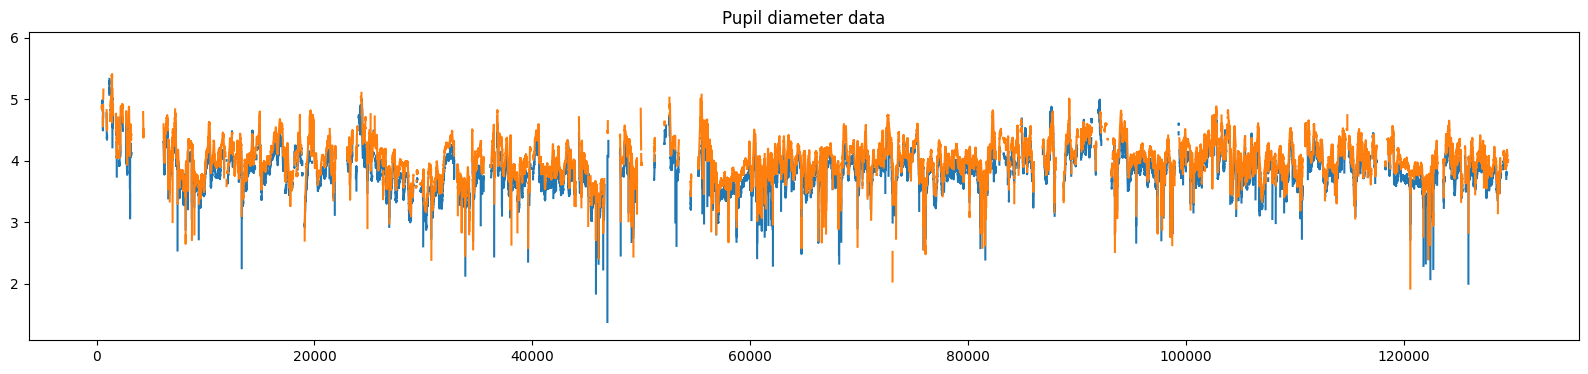

In [27]:
# Plot left_pupil_diameter and right_pupil_diameter
plt.figure(figsize=(20, 4))
plt.plot(et_df['left_pupil_diameter'][:1300000], label='left_pupil_diameter');
plt.plot(et_df['right_pupil_diameter'][:1300000], label='right_pupil_diameter');
plt.title('Pupil diameter data');

<Axes: >

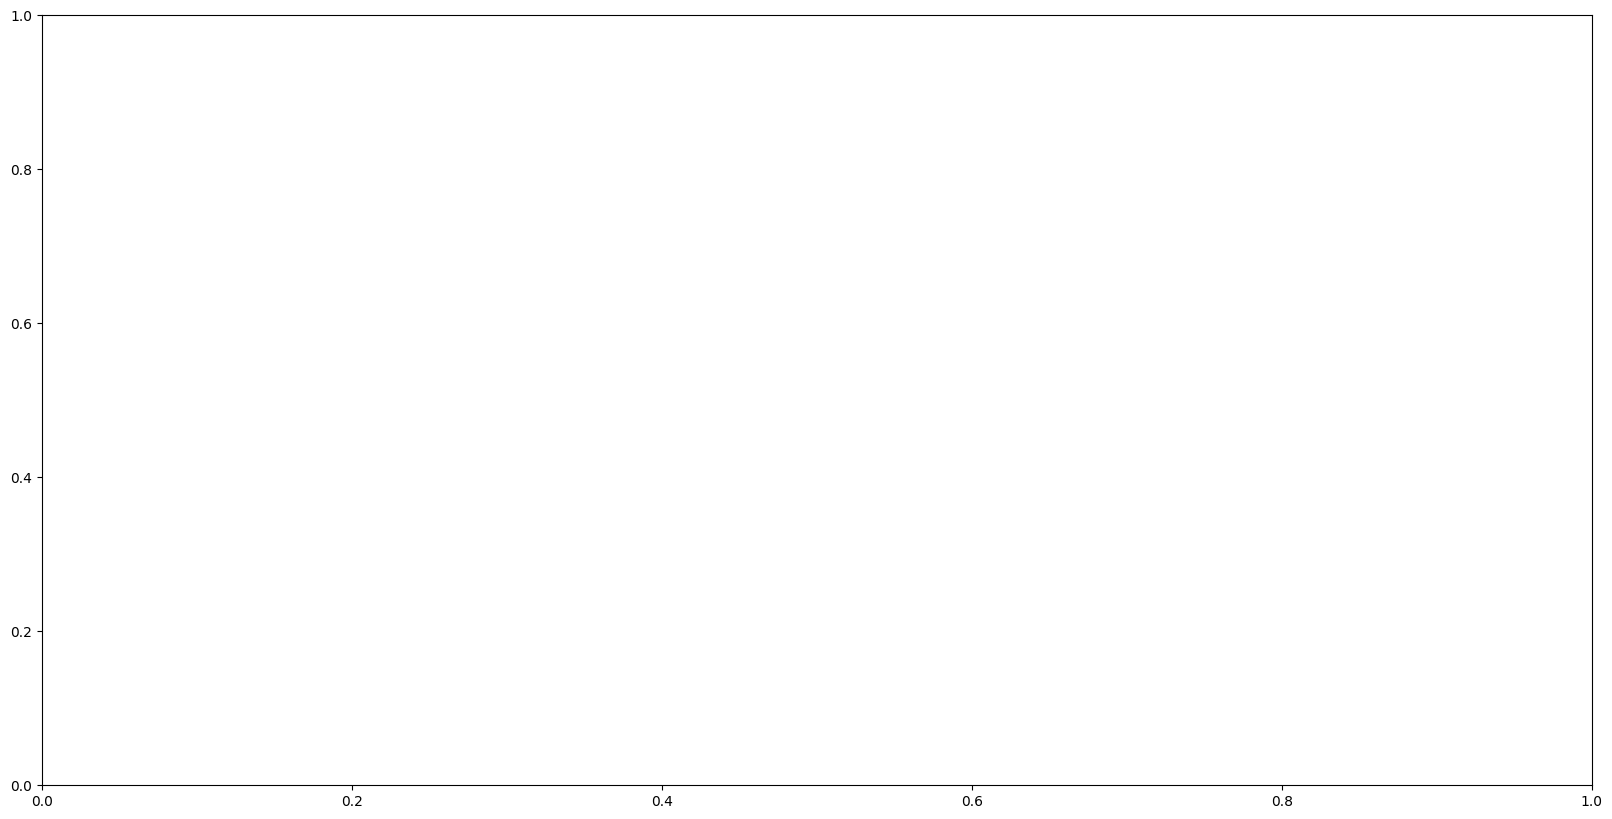

In [28]:

evnt_of_interest = 'CampFriend'
onset = stim_df.loc[stim_df.event == 'Onset_'+ evnt_of_interest, 'time'].values[0]
offset = stim_df.loc[stim_df.event == 'Offset_'+ evnt_of_interest, 'time'].values[0]
left_x = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'left_gaze_point_on_display_area_0']
left_y = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'left_gaze_point_on_display_area_1']
left = pd.DataFrame({'x': left_x, 'y': left_y})
# Right
right_x = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'right_gaze_point_on_display_area_0']
right_y = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'right_gaze_point_on_display_area_1']
right = pd.DataFrame({'x': right_x, 'y': right_y})
fig, ax = plt.subplots( figsize=(20, 10))
sns.scatterplot(data=right, x='x', y='y', color='r')
#ax[0].set_title('Right eye')
sns.scatterplot(data=left, x='x', y='y', color='b')
#ax[1].set_title('Left eye')

In [ ]:
ET = data[streams_collected.index('Tobii')]
et_dat = ET['time_series']

In [23]:
# Get the units associated with each eyetracking variable
ET['info']['desc'][0]#['channels'][0]['channel'][0]['unit'][0]

defaultdict(list,
            {'manufacturer': ['Tobii'],
             'channels': [defaultdict(list,
                          {'channel': [defaultdict(list,
                                        {'label': ['device_time_stamp'],
                                         'unit': ['device'],
                                         'type': ['ET']}),
                            defaultdict(list,
                                        {'label': ['left_gaze_origin_validity'],
                                         'unit': ['device'],
                                         'type': ['ET']}),
                            defaultdict(list,
                                        {'label': ['right_gaze_origin_validity'],
                                         'unit': ['device'],
                                         'type': ['ET']}),
                            defaultdict(list,
                                        {'label': ['left_gaze_origin_in_user_coordinate_system_0'],
       

# EEG

In [49]:
EEG = data[streams_collected.index('EGI NetAmp 0')]
eeg_dat = pd.DataFrame(EEG['time_series'])
#eeg_dat['lsl_time_stamp'] = EEG['time_stamps']

Apply Notch Filter?

In [50]:
def apply_notch_filter(data, fs, f0, Q):
    nyquist = 0.5 * fs
    w0 = f0 / nyquist
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data)

filtered_eeg = eeg_dat.apply(lambda x: apply_notch_filter(x, 1000, 60, 30))

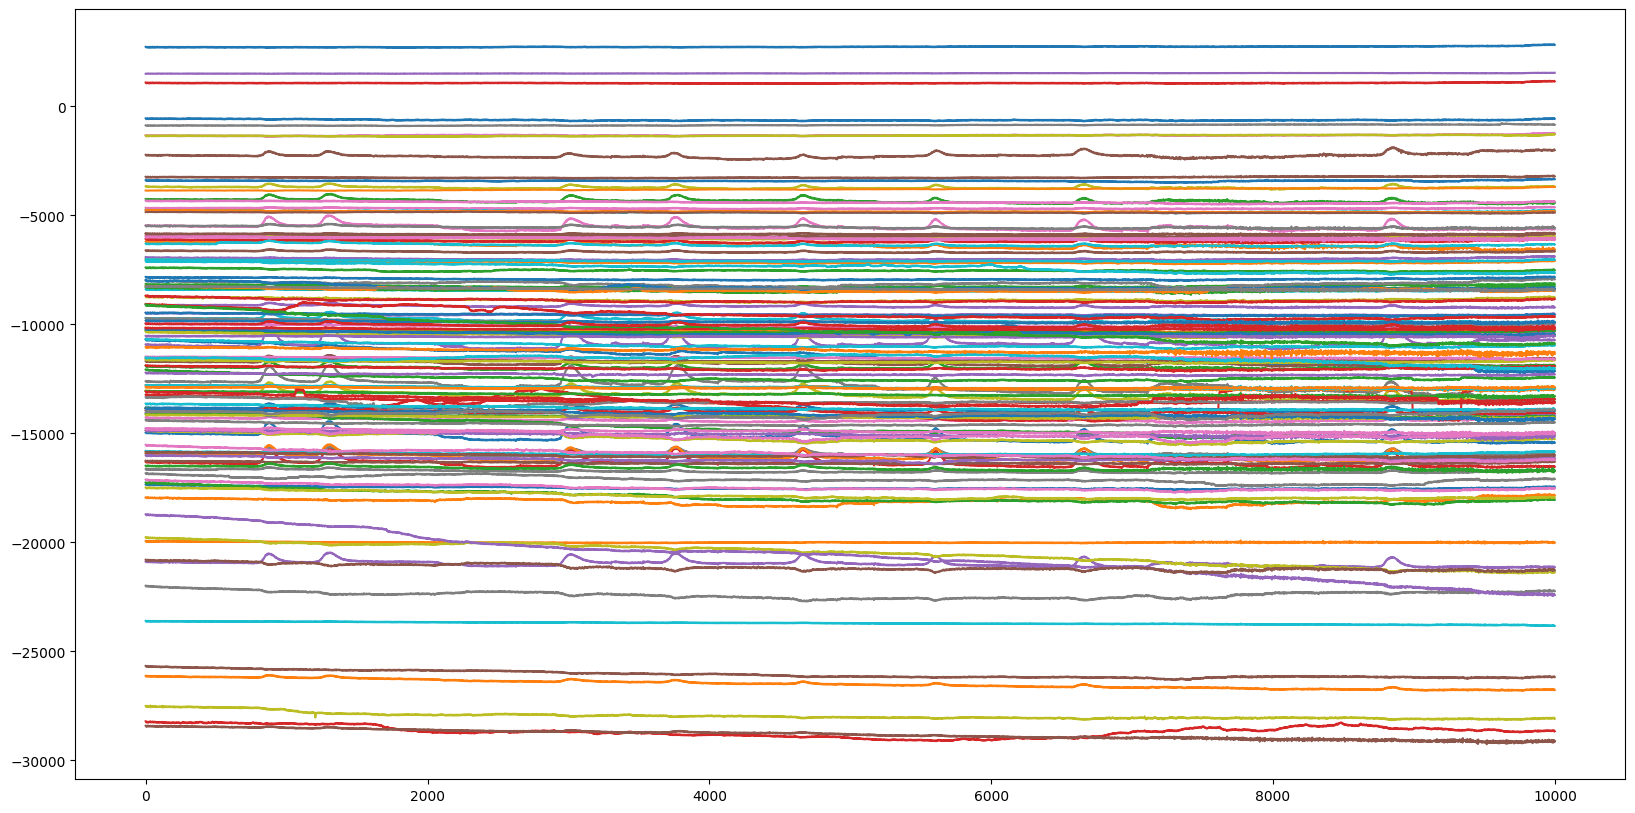

In [60]:
# plot the EEG data
plt.figure(figsize=(20, 10))
plt.plot(filtered_eeg[:10000]);


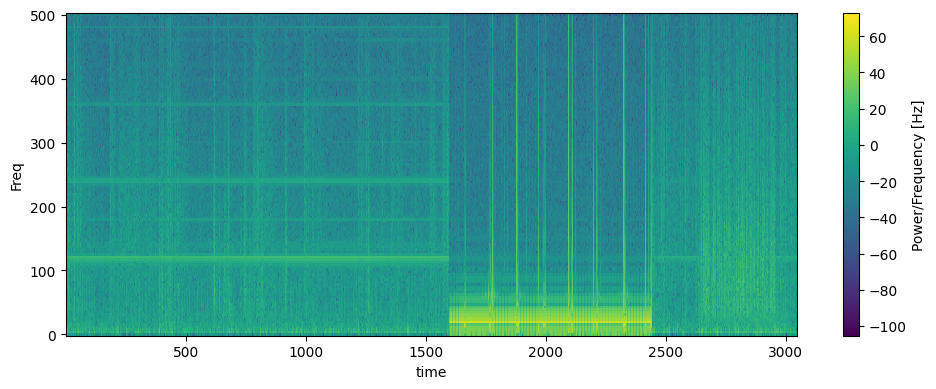

In [57]:
rest_eeg = filtered_eeg #eeg_dat[:-1] #get_event_data('RestingState', eeg_dat)
from scipy.signal import spectrogram

plt.figure(figsize=(10, 4))

for column in rest_eeg.columns:
    f, t, Sxx = spectrogram(rest_eeg[column], fs=1000)

    plt.pcolormesh(t, f, 10 *np.log10(Sxx), shading='nearest')

plt.colorbar(label='Power/Frequency [Hz]')
plt.ylabel('Freq')
plt.xlabel('time')
plt.tight_layout()
plt.show()

In [37]:
from scipy.signal import spectrogram

plt.figure(figsize=(10, 4))

for column in eeg_dat.columns:
    f, t, Sxx = spectrogram(eeg_dat[column], fs=250)

    plt.pcolormesh(t, f, 10 *np.log10(Sxx), shading='nearest')

plt.colorbar(label='Power/Frequency [Hz]')
plt.ylabel('Freq')
plt.xlabel('time')
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

<Figure size 1000x400 with 0 Axes>